# Project

이번 프로젝트에서는 Pi-model, Mean Teacher, VAT 등의 SSL 방법을 활용해서 CWRU 베어링 데이터의 Semi-supervised Classification을 실험합니다.

Encoder 구조도 수정을 했던 지난 프로젝트와 달리, WDCNN으로 고정된 Encoder를 바탕으로 적합한 SSL 방법론을 활용해 높은 성능을 달성하는 것이 목표입니다.


*참고:*
- *00_SSL_tutorial.ipynb*
- *01_Bearing_tutorial.ipynb*
- *A1_UsefulNotebook.ipynb*

In [2]:
# enable auto reload
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import math

In [6]:
## fix seeds for reproducibility
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

## 1. Preprocessed Data 로드

In [4]:
from src.utils.data_utils import CWRUDataset

P=0.001

train_dataset = CWRUDataset('./data','train',p=P)
test_dataset = CWRUDataset('./data','test',p=P)

train dataset size:14950, labeled:14, unlabeled:14936
masks : [0:1, 1:2, 2:1, 3:2, 4:1, 5:1, 6:1, 7:2, 8:1, 9:2]
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]


## 2. Baseline : Consistency Model

In [1]:
## Train configurations
LR0 = 1e-3        ## learning rate
BATCH0 = 32      ## batch size
EPOCH0 = 100      ## # of epochs to run
SAVE_PATH = './saved_models'  ## path to save model weights
LOG_PATH = './train_logs'  ## path to save train logs
TEST_PATH = './test_results'  ## path to save test results

## Make necessary directories
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)
if not os.path.exists(TEST_PATH):
    os.mkdir(TEST_PATH)
    
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

NameError: name 'os' is not defined

In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH0, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH0)

In [10]:
from src.model import WDCNN

def CrossEntropy(q,p):
    b = F.softmax(p, dim=1) * F.log_softmax(q, dim=1)
    b = -1.0*b.mean()
    return b

class ConsistencyModel(WDCNN):
    def __init__(self, model_name='consistency_model',*args, **kwargs):
        super(ConsistencyModel, self).__init__(model_name=model_name, *args,**kwargs)
    def batch_step(self, batch, label, mask, optimizer=None):
            
        ## regularize consistency with 1-shift data
        batch_original = batch[:,:,:-1]
        batch_perturbed = batch[:,:,1:]
        
        ## Forward pass for original data
        p_original, loss, z = self.forward(batch_original, label, mask)
        
        ## Forward pass for shifted data
        p_perturbed, _, _ = self.forward(batch_perturbed, label, mask)
        
        ## compute distance loss
        dist_loss = CrossEntropy(p_perturbed, p_original)
        
        if loss is None:
            loss = torch.tensor(0.0)
        loss = loss + dist_loss
        
        if self.training and (loss is not None):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        return loss, p_original, z
        

In [12]:
## generate consistency model
model = ConsistencyModel(p=P)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR0)

train_dataset = CWRUDataset('./data','train',p=P)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH0, shuffle=True)

model.train_model(train_dataloader, test_dataloader, EPOCH0, optimizer)

Model Name : consistency_model_p0020
train dataset size:14950, labeled:29, unlabeled:14921
masks : [0:3, 1:2, 2:1, 3:2, 4:3, 5:3, 6:4, 7:4, 8:3, 9:4]
(7.13s) [Epoch 0]
	Train Loss : 0.40101,	Train Acc : 0.11304
	Eval Loss : 3.31909,	Eval Acc : 0.10000
(5.23s) [Epoch 1]
	Train Loss : 0.31007,	Train Acc : 0.18816
	Eval Loss : 2.61917,	Eval Acc : 0.20000
(5.42s) [Epoch 2]
	Train Loss : 0.23756,	Train Acc : 0.19699
	Eval Loss : 3.29349,	Eval Acc : 0.26170
(5.32s) [Epoch 3]
	Train Loss : 0.24271,	Train Acc : 0.25652
	Eval Loss : 2.46795,	Eval Acc : 0.29707
(5.24s) [Epoch 4]
	Train Loss : 0.21041,	Train Acc : 0.29204
	Eval Loss : 2.56116,	Eval Acc : 0.29920
(5.30s) [Epoch 5]
	Train Loss : 0.16762,	Train Acc : 0.30401
	Eval Loss : 2.67775,	Eval Acc : 0.34468
(5.28s) [Epoch 6]
	Train Loss : 0.14064,	Train Acc : 0.32100
	Eval Loss : 3.51400,	Eval Acc : 0.14335
(5.26s) [Epoch 7]
	Train Loss : 0.13090,	Train Acc : 0.30027
	Eval Loss : 4.02933,	Eval Acc : 0.32793
(5.29s) [Epoch 8]
	Train Loss : 0.

(5.33s) [Epoch 79]
	Train Loss : 0.00020,	Train Acc : 0.46528
	Eval Loss : 11.65608,	Eval Acc : 0.46303
(5.39s) [Epoch 80]
	Train Loss : 0.10759,	Train Acc : 0.39003
	Eval Loss : 7.18191,	Eval Acc : 0.48856
(5.38s) [Epoch 81]
	Train Loss : 0.02337,	Train Acc : 0.46589
	Eval Loss : 7.78442,	Eval Acc : 0.46410
(5.32s) [Epoch 82]
	Train Loss : 0.00423,	Train Acc : 0.46441
	Eval Loss : 9.08650,	Eval Acc : 0.46303
(5.34s) [Epoch 83]
	Train Loss : 0.00272,	Train Acc : 0.46515
	Eval Loss : 8.74910,	Eval Acc : 0.46330
(5.24s) [Epoch 84]
	Train Loss : 0.00200,	Train Acc : 0.46528
	Eval Loss : 9.12491,	Eval Acc : 0.46303
(5.28s) [Epoch 85]
	Train Loss : 0.00202,	Train Acc : 0.46441
	Eval Loss : 9.51268,	Eval Acc : 0.46277
(5.40s) [Epoch 86]
	Train Loss : 0.00140,	Train Acc : 0.46502
	Eval Loss : 9.72163,	Eval Acc : 0.46277
(5.34s) [Epoch 87]
	Train Loss : 0.00106,	Train Acc : 0.46528
	Eval Loss : 9.84590,	Eval Acc : 0.46277
(5.37s) [Epoch 88]
	Train Loss : 0.00089,	Train Acc : 0.46515
	Eval Loss

# 3. YOUR CODE FROM HERE: Your Model

In [11]:
## Train configurations
LR = LR0        ## learning rate
BATCH = BATCH0      ## batch size
EPOCH = EPOCH0      ## # of epochs to run

In [12]:
class MyModel(WDCNN):
    def __init__(self, model_name='my_model',*args, **kwargs):
        super(MyModel, self).__init__(model_name=model_name, *args,**kwargs)
        '''
        YOUR CODE HERE (optional)
        '''
    def batch_step(self, batch, label, mask, optimizer=None):
        '''
        YOUR CODE HERE (necessary)
        '''
        return NotImplementedError
    '''
    YOUR METHODS HERE (optional)
    '''

In [21]:
## generate your model
model = MyModel(p=P, model_name = 'my_model')
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_dataset = CWRUDataset('./data','train',p=P)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

model.train_model(train_dataloader, test_dataloader, EPOCH, optimizer)

Model Name : my_mt_model_p0010
Model Name : wdcnn_p0010
train dataset size:14950, labeled:14, unlabeled:14936
masks : [0:1, 1:2, 2:1, 3:2, 4:1, 5:1, 6:1, 7:2, 8:1, 9:2]
(5.09s) [Epoch 0]
	Train Loss : 0.29233,	Train Acc : 0.24000
	Eval Loss : 2.33086,	Eval Acc : 0.21197
(5.03s) [Epoch 1]
	Train Loss : 0.27873,	Train Acc : 0.26609
	Eval Loss : 2.07463,	Eval Acc : 0.32394
(5.08s) [Epoch 2]
	Train Loss : 0.24714,	Train Acc : 0.33893
	Eval Loss : 1.91840,	Eval Acc : 0.37314
(5.06s) [Epoch 3]
	Train Loss : 0.22146,	Train Acc : 0.38154
	Eval Loss : 1.91508,	Eval Acc : 0.41888
(5.04s) [Epoch 4]
	Train Loss : 0.21981,	Train Acc : 0.38502
	Eval Loss : 1.75409,	Eval Acc : 0.43883
(5.01s) [Epoch 5]
	Train Loss : 0.20114,	Train Acc : 0.41077
	Eval Loss : 1.73674,	Eval Acc : 0.43245
(5.03s) [Epoch 6]
	Train Loss : 0.17885,	Train Acc : 0.44615
	Eval Loss : 1.55070,	Eval Acc : 0.54574
(5.02s) [Epoch 7]
	Train Loss : 0.16444,	Train Acc : 0.50047
	Eval Loss : 1.48979,	Eval Acc : 0.52261
(5.17s) [Epoch 

(5.68s) [Epoch 78]
	Train Loss : 0.11109,	Train Acc : 0.62167
	Eval Loss : 1.55272,	Eval Acc : 0.64122
(5.68s) [Epoch 79]
	Train Loss : 0.11112,	Train Acc : 0.62562
	Eval Loss : 1.56997,	Eval Acc : 0.64282
(5.79s) [Epoch 80]
	Train Loss : 0.11372,	Train Acc : 0.61993
	Eval Loss : 1.55889,	Eval Acc : 0.65000
(5.66s) [Epoch 81]
	Train Loss : 0.11480,	Train Acc : 0.62147
	Eval Loss : 1.61847,	Eval Acc : 0.63883
(5.56s) [Epoch 82]
	Train Loss : 0.11394,	Train Acc : 0.62475
	Eval Loss : 1.68267,	Eval Acc : 0.64309
(5.40s) [Epoch 83]
	Train Loss : 0.11456,	Train Acc : 0.61913
	Eval Loss : 1.69201,	Eval Acc : 0.64255
(5.20s) [Epoch 84]
	Train Loss : 0.11533,	Train Acc : 0.62114
	Eval Loss : 1.65592,	Eval Acc : 0.65824
(5.13s) [Epoch 85]
	Train Loss : 0.11674,	Train Acc : 0.62401
	Eval Loss : 1.69692,	Eval Acc : 0.65186
(5.26s) [Epoch 86]
	Train Loss : 0.11550,	Train Acc : 0.62174
	Eval Loss : 1.61038,	Eval Acc : 0.64787
(5.63s) [Epoch 87]
	Train Loss : 0.11658,	Train Acc : 0.62375
	Eval Loss 

# 4. Analysis

In [18]:
from src.utils.exp_utils import *

No consistency_model_p0010


D:\lg\src\utils\exp_utils.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(2,2,i+1)


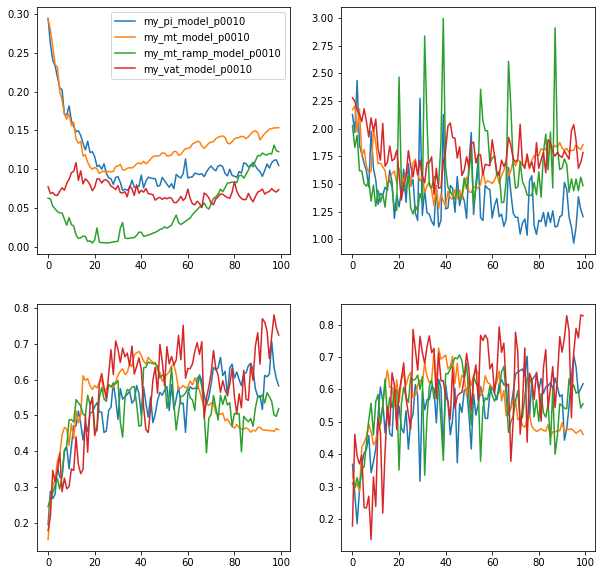

In [19]:
MODEL_NAMES = []  ## ex) ['consistency_model','my_model1','my_model2']
MODEL_NAMES = [x+'_p%04d'%(10000*P) for x in MODEL_NAMES]
plot_logs(MODEL_NAMES,LOG_PATH)

In [17]:
MODEL_NAME_EPOCHS = []  ## ex) ['consistency_model_p0010_e100','my_model1_p0010_e100','my_model2_p0010_e100']
MODELS = []  ## ex) [ConsistencyModel, MyModel, MyModel]
for i in range(len(MODEL_NAME_EPOCHS)):
    model = MODELS[i](model_name = MODEL_NAME_EPOCHS[i])
    model.load_state_dict(torch.load(SAVE_PATH+'/'+MODEL_NAME_EPOCHS[i]+'.pth'))
    
    test_model(model,overwrite=False)
    test_model(model, split='train',overwrite=False)

Model Name : my_mt_model_p0010_e100
Model Name : wdcnn


NameError: name 'test_model' is not defined

<IPython.core.display.Javascript object>


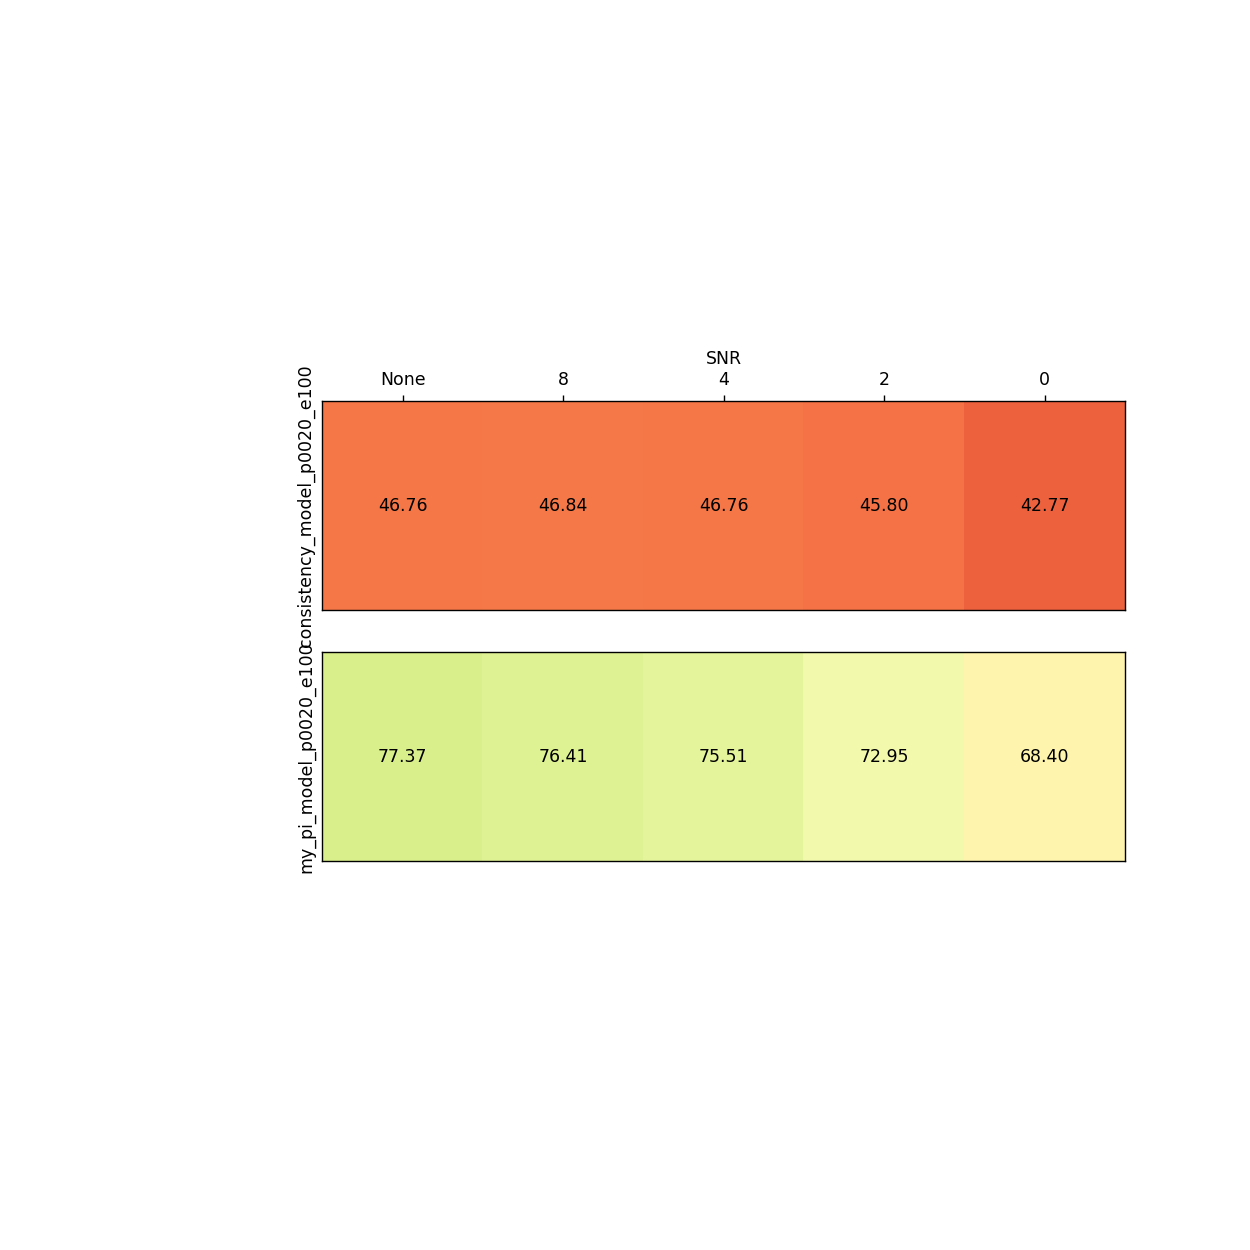

In [150]:
MODEL_NAME_EPOCHS = []  ## ex) ['consistency_model_p0010_e100','my_model1_p0010_e100','my_model2_p0010_e100']
fig=plt.figure(figsize=(10,10))
make_table(MODEL_NAME_EPOCHS)

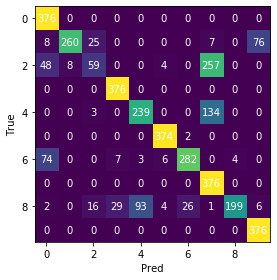

In [19]:
MODEL_NAME_EPOCH = '' ## ex) 'my_model1_p0010_e100'
make_confmat(model_name = MODEL_NAME_EPOCH, snr=None)

train dataset size:14950, labeled:29, unlabeled:14921
masks : [0:3, 1:2, 2:1, 3:2, 4:3, 5:3, 6:4, 7:4, 8:3, 9:4]


C:\Users\jh\AppData\Roaming\Python\Python36\site-packages\matplotlib\collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


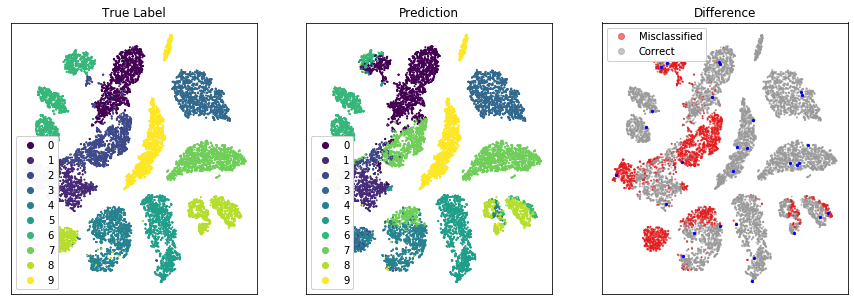

In [21]:
MODEL_NAME_EPOCH = '' ## ex) 'my_model1_p0010_e100'

plot_latent(MODEL_NAME_EPOCH, split='train', p=P, mode='pca')
#plot_latent(MODEL_NAME_EPOCH, split='train', p=P, mode='tsne')

<IPython.core.display.Javascript object>


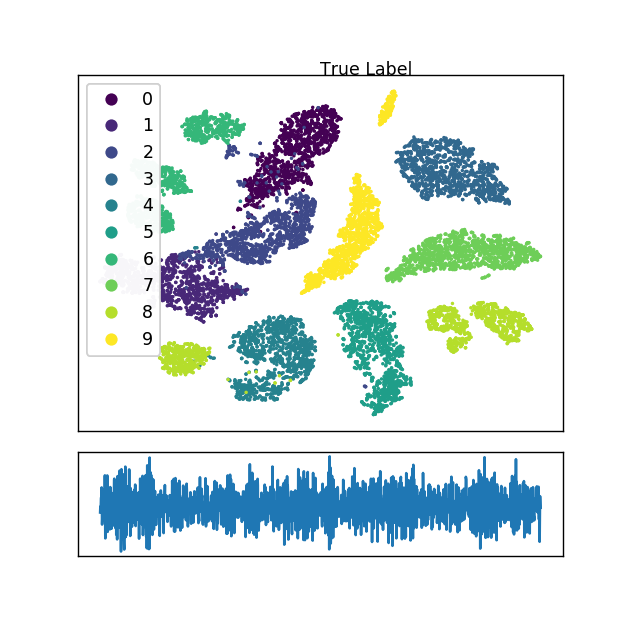

train dataset size:14950, labeled:29, unlabeled:14921
masks : [0:3, 1:2, 2:1, 3:2, 4:3, 5:3, 6:4, 7:4, 8:3, 9:4]


In [22]:
%matplotlib notebook
MODEL_NAME_EPOCH = '' ## ex) 'my_model1_p0010_e100'

draw_magic(MODEL_NAME_EPOCH,split='train',p=P, legend=True, mode='pca')
#draw_magic(MODEL_NAME_EPOCH,split='train',p=P, legend=True, mode='tsne')